In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


First of all, let's look at the data. You can see, that our datasets have three columns with type "object" and two columns with type "int". And two of them have null values. Personally, I will use only "text" column for my prediction.

In [2]:
tweets_csv = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
tweets_csv.info()
tweets_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Obviously, we have a binary classification problem, so, next, let's look at our target distribution. As we can see, both classes have approximately equal number of examples.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Count'>

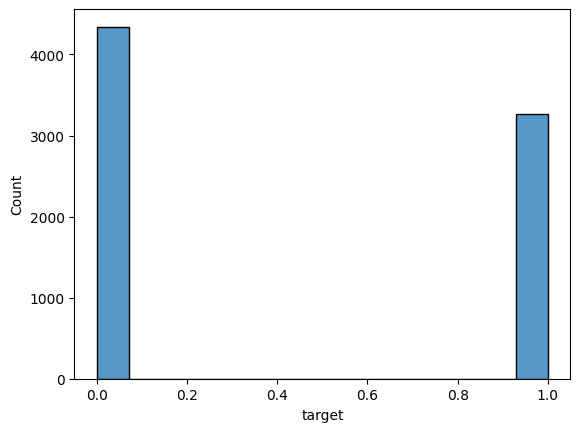

In [3]:
sns.histplot(data=tweets_csv, x="target")

Now, we will write a preprocessing function, which will clear our input text.

In [4]:
%pip install contractions

import re
import nltk
import contractions
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(input_text):
    clean_text = re.sub('<[^<]+?>', '', input_text)
    clean_text = re.sub(r'http\S+', '', clean_text)
    clean_text = clean_text.lower()
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    clean_text = contractions.fix(clean_text)
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)
     
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)
    
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    return clean_text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
tweets_texts = tweets_csv.loc[:, ['text']]
tweets_texts.shape

(7613, 1)

Next few cells will be dedicated to the comparison of raw and preprocessed data.

In [6]:
tweets_list = tweets_texts.values.tolist()
tweets_list[7600:]

[['Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1'],
 ['#breaking #LA Refugio oil spill may have been costlier bigger than projected http://t.co/5ueCmcv2Pk'],
 ["a siren just went off and it wasn't the Forney tornado warning ??"],
 ['Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY'],
 ['#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm'],
 ["on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not"],
 ['Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje'],
 ['#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp'],
 ['Two giant cranes holding a bridge collapse i

In [7]:
preprocessed_data = [clean_text(string) for string in tweets_texts['text']]
preprocessed_data[7600:]

['evacuation order lifted town roosevelt',
 'breaking la refugio oil spill may costlier bigger projected',
 'siren went forney tornado warning',
 'officials say quarantine place alabama home possible ebola case developing symptoms',
 'worldnews fallen powerlines glink tram update fire crews evacuated 30 passengers tr',
 'flip side walmart bomb everyone evacuate stay tuned blow',
 'suicide bomber kills 15 saudi security site mosque reuters via world google news wall',
 'stormchase violent record breaking ef5 el reno oklahoma tornado nearly runs',
 'two giant cranes holding bridge collapse nearby homes',
 'ariaahrary thetawniest control wild fires california even northern part state troubling',
 'm194 0104 utc5km volcano hawaii',
 'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries',
 'latest homes razed northern california wildfire abc news']

We have to divide data in train and test sets.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(preprocessed_data, tweets_csv['target'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Size of training: ", len(X_train))
print("Size of test: ", len(X_test))
print("Size of validation: ", len(X_valid))

Size of training:  5480
Size of test:  1371
Size of validation:  762


Then we will build, train and compare two models: SGDClassifier and KNeighborsClassifier.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [10]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
sgd_ppl_clf.fit(X_train, y_train)
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

In [11]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       817
           1       0.70      0.75      0.73       554

    accuracy                           0.77      1371
   macro avg       0.76      0.77      0.76      1371
weighted avg       0.77      0.77      0.77      1371



In [12]:
predicted_sgd = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       920
           1       0.63      0.82      0.71       451

    accuracy                           0.78      1371
   macro avg       0.76      0.79      0.77      1371
weighted avg       0.81      0.78      0.79      1371



We will choose SGDClassifier. Also, we can lightly improve our model, using different parameters (The result will be better in 3%)

In [13]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       788
           1       0.74      0.74      0.74       583

    accuracy                           0.78      1371
   macro avg       0.77      0.77      0.77      1371
weighted avg       0.78      0.78      0.78      1371



Finally, we have to create our submission file 

In [14]:
test_csv = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
ids = test_csv.pop('id')
predicted_data = sgd_ppl_clf.predict(test_csv['text'])
output = pd.DataFrame({'id': ids, 'target': predicted_data})
output.to_csv('submission.csv', index = False)
print("Your submission was successfully saved")

Your submission was successfully saved
